<a href="https://colab.research.google.com/github/xchen35/Model_Imagenet32/blob/master/TL_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, BatchNormalization, Activation
from keras.models import Model
from keras.metrics import top_k_categorical_accuracy, categorical_accuracy
from keras.engine.topology import get_source_inputs
from keras.layers import DepthwiseConv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10 
from keras import optimizers,regularizers
import numpy as np
from skimage.transform import resize
from keras import models
from keras import layers
import matplotlib.pyplot as plt
import os

In [0]:
#base setup
batch_size = 64
num_classes = 10
epochs = 20
num_predictions = 20
weight_decay=1e-4

In [0]:
def color_preprocessing(x_train,x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    mean = [125.307, 122.95, 113.865]
    std  = [62.9932, 62.0887, 66.7048]
    for i in range(3):
        x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
        x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
    return x_train, x_test

def scheduler(epoch):
    if epoch < 100:
        return 0.01
    if epoch < 200:
        return 0.001
    return 0.0001

# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)
x_train, x_test = color_preprocessing(x_train, x_test)

In [0]:
def depthwise_separable(x,params):
    # f1/f2 filter size, s1 stride of conv
    (s1,f2) = params
    x = DepthwiseConv2D((3,3),strides=(s1[0],s1[0]), padding='same',depthwise_initializer="he_normal")(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Conv2D(int(f2[0]), (1,1), strides=(1,1), padding='same',
               kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Activation('relu')(x)
    return x

In [0]:
def MobileNet(img_input, alpha=1, shallow=False, classes=10):
    
    x = Conv2D(int(32), (3,3), strides=(2,2), padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = depthwise_separable(x,params=[(1,),(64,)])
    x = depthwise_separable(x,params=[(2,),(128,)])
    x = depthwise_separable(x,params=[(1,),(128,)])
    x = depthwise_separable(x,params=[(2,),(256,)])
    x = depthwise_separable(x,params=[(1,),(256,)])
    x = depthwise_separable(x,params=[(2,),(512,)])
    
    if not shallow:
        for _ in range(5):
            x = depthwise_separable(x,params=[(1,),(512,)])
            
    x = depthwise_separable(x,params=[(2,),(1024,)])
    x = depthwise_separable(x,params=[(1,),(1024,)])

    x = GlobalAveragePooling2D()(x)
    out = Dense(classes, activation='softmax')(x)
    return out

In [0]:
img_input=Input(shape=(32,32,3))
output = MobileNet(img_input)
model=Model(img_input,output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization_55 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
activation_55 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________________
depthwise_conv2d_27 (Depthwi (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_56 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
activation_56 (Activation)   (None, 16, 16, 32)        0         
__________

In [0]:
# set optimizer
sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# set data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',cval=0.)
datagen.fit(x_train)

# start training
history = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))
model.save('mobilenet.h5')

Epoch 1/20
781/781 [==============================] - 62s 80ms/step - loss: 4.1383 - acc: 0.2751 - val_loss: 3.6477 - val_acc: 0.3724
Epoch 2/20
781/781 [==============================] - 53s 67ms/step - loss: 3.9438 - acc: 0.2849 - val_loss: 3.7838 - val_acc: 0.3146
Epoch 3/20
781/781 [==============================] - 52s 66ms/step - loss: 3.8645 - acc: 0.2919 - val_loss: 3.6682 - val_acc: 0.3338
Epoch 4/20
781/781 [==============================] - 52s 67ms/step - loss: 3.6135 - acc: 0.3359 - val_loss: 3.1798 - val_acc: 0.3826
Epoch 5/20
781/781 [==============================] - 52s 67ms/step - loss: 4.6425 - acc: 0.2909 - val_loss: 7.0428 - val_acc: 0.1976
Epoch 6/20
781/781 [==============================] - 52s 66ms/step - loss: 6.3030 - acc: 0.2151 - val_loss: 5.8704 - val_acc: 0.2398
Epoch 7/20
781/781 [==============================] - 52s 66ms/step - loss: 5.0400 - acc: 0.2718 - val_loss: 4.5612 - val_acc: 0.3272
Epoch 8/20
781/781 [==============================] - 52s 66ms

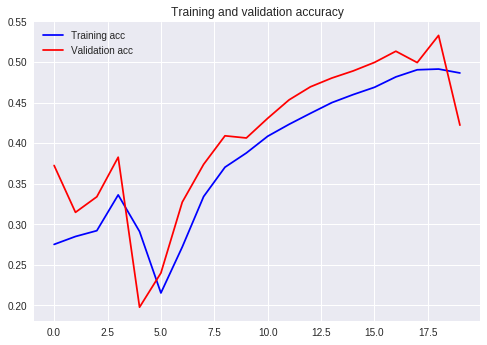

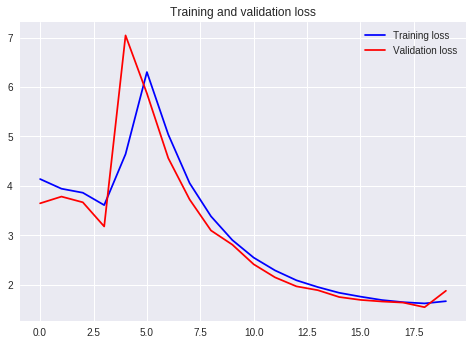

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epoch = range(len(acc))
 
plt.plot(epoch, acc, 'b', label='Training acc')
plt.plot(epoch, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epoch, loss, 'b', label='Training loss')
plt.plot(epoch, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [0]:
# Transfer Learning



In [0]:
# add a global spatial average pooling layer
x = model.output
# x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
# and a logistic layer -- 10 classes for CIFAR10
predictions = Dense(num_classes, activation='softmax')(x)

In [0]:
# this is the model we will train
model_trans = Model(inputs=model.input, outputs=predictions)
model_trans.summary()
for i,layer in enumerate(model_trans.layers):
  print(i,layer.name)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization_55 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
activation_55 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________________
depthwise_conv2d_27 (Depthwi (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_56 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
activation_56 (Activation)   (None, 16, 16, 32)        0         
__________

In [0]:
# set optimizer

model_trans.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# set data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',cval=0.)
datagen.fit(x_train)

# start training
history = model_trans.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))
model_trans.save('mobilenet_transferLearning.h5')

Epoch 1/20
781/781 [==============================] - 65s 83ms/step - loss: 1.8128 - acc: 0.4468 - val_loss: 1.5990 - val_acc: 0.5210
Epoch 2/20
781/781 [==============================] - 55s 70ms/step - loss: 1.6547 - acc: 0.4960 - val_loss: 1.5512 - val_acc: 0.5168
Epoch 3/20
781/781 [==============================] - 54s 69ms/step - loss: 1.6063 - acc: 0.5069 - val_loss: 1.5665 - val_acc: 0.5235
Epoch 4/20
781/781 [==============================] - 54s 69ms/step - loss: 1.5871 - acc: 0.5142 - val_loss: 1.4737 - val_acc: 0.5468
Epoch 5/20
781/781 [==============================] - 54s 69ms/step - loss: 1.5436 - acc: 0.5258 - val_loss: 1.4647 - val_acc: 0.5465
Epoch 6/20
781/781 [==============================] - 53s 68ms/step - loss: 1.5261 - acc: 0.5342 - val_loss: 1.4159 - val_acc: 0.5746
Epoch 7/20
781/781 [==============================] - 54s 69ms/step - loss: 1.5017 - acc: 0.5417 - val_loss: 1.4705 - val_acc: 0.5545
Epoch 8/20
781/781 [==============================] - 53s 68ms

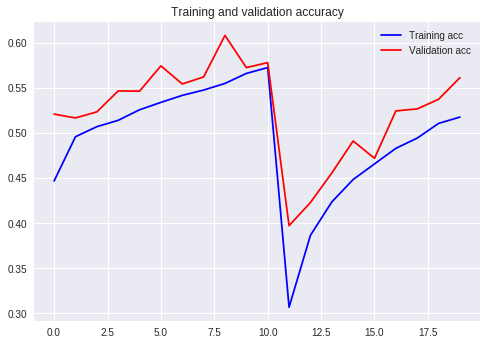

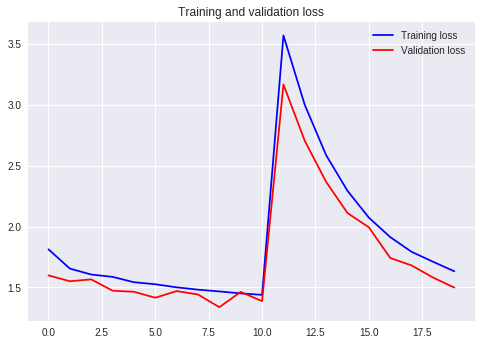

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epoch = range(len(acc))
 
plt.plot(epoch, acc, 'b', label='Training acc')
plt.plot(epoch, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epoch, loss, 'b', label='Training loss')
plt.plot(epoch, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [0]:
#Fine Tuning
# we should freeze:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_3
1 conv2d_29
2 batch_normalization_55
3 activation_55
4 depthwise_conv2d_27
5 batch_normalization_56
6 activation_56
7 conv2d_30
8 batch_normalization_57
9 activation_57
10 depthwise_conv2d_28
11 batch_normalization_58
12 activation_58
13 conv2d_31
14 batch_normalization_59
15 activation_59
16 depthwise_conv2d_29
17 batch_normalization_60
18 activation_60
19 conv2d_32
20 batch_normalization_61
21 activation_61
22 depthwise_conv2d_30
23 batch_normalization_62
24 activation_62
25 conv2d_33
26 batch_normalization_63
27 activation_63
28 depthwise_conv2d_31
29 batch_normalization_64
30 activation_64
31 conv2d_34
32 batch_normalization_65
33 activation_65
34 depthwise_conv2d_32
35 batch_normalization_66
36 activation_66
37 conv2d_35
38 batch_normalization_67
39 activation_67
40 depthwise_conv2d_33
41 batch_normalization_68
42 activation_68
43 conv2d_36
44 batch_normalization_69
45 activation_69
46 depthwise_conv2d_34
47 batch_normalization_70
48 activation_70
49 conv2d_37
50 batch_n

In [0]:
# Freeze the layers except the last 4 layers
for layer in model.layers[:-4]:
    layer.trainable = False
    
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fdce86e3f60> False
<keras.layers.convolutional.Conv2D object at 0x7fdce86e3358> False
<keras.layers.normalization.BatchNormalization object at 0x7fdce86c2550> False
<keras.layers.core.Activation object at 0x7fdce86f4f28> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fdce8659710> False
<keras.layers.normalization.BatchNormalization object at 0x7fdce86597f0> False
<keras.layers.core.Activation object at 0x7fdce938ea58> False
<keras.layers.convolutional.Conv2D object at 0x7fdce9313da0> False
<keras.layers.normalization.BatchNormalization object at 0x7fdce92de8d0> False
<keras.layers.core.Activation object at 0x7fdce93313c8> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fdce888f390> False
<keras.layers.normalization.BatchNormalization object at 0x7fdce9260c18> False
<keras.layers.core.Activation object at 0x7fdce91f66a0> False
<keras.layers.convolutional.Conv2D object at 0x7fdce91bc1d0> False
<keras.layers.

In [0]:
# Create the model
model_finetune = models.Sequential()

# Add the vgg convolutional base model
model_finetune.add(model)

# let's add a fully-connected layer
model_finetune.add(layers.Dense(1024, activation='relu'))
model_finetune.add(layers.Dropout(0.5))
model_finetune.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization_55 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
activation_55 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________________
depthwise_conv2d_27 (Depthwi (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_56 (Batc (None, 16, 16, 32)        128       
___________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
# set optimizer
model_finetune.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# set data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',cval=0.)
datagen.fit(x_train)

# start training
history = model_finetune.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))
model_finetune.save('mobilenet_fineTuning.h5')

Epoch 1/20
781/781 [==============================] - 43s 55ms/step - loss: 1.6183 - acc: 0.5349 - val_loss: 1.4917 - val_acc: 0.5639
Epoch 2/20
781/781 [==============================] - 33s 42ms/step - loss: 1.5720 - acc: 0.5417 - val_loss: 1.4705 - val_acc: 0.5776
Epoch 3/20
781/781 [==============================] - 33s 42ms/step - loss: 1.5751 - acc: 0.5384 - val_loss: 1.4904 - val_acc: 0.5643
Epoch 4/20
781/781 [==============================] - 32s 41ms/step - loss: 1.5692 - acc: 0.5399 - val_loss: 1.5339 - val_acc: 0.5451
Epoch 5/20
781/781 [==============================] - 34s 43ms/step - loss: 1.5650 - acc: 0.5365 - val_loss: 1.5189 - val_acc: 0.5592
Epoch 6/20
781/781 [==============================] - 33s 42ms/step - loss: 1.5675 - acc: 0.5402 - val_loss: 1.4661 - val_acc: 0.5732
Epoch 7/20
781/781 [==============================] - 33s 42ms/step - loss: 1.5627 - acc: 0.5382 - val_loss: 1.5067 - val_acc: 0.5529
Epoch 8/20
781/781 [==============================] - 33s 42ms

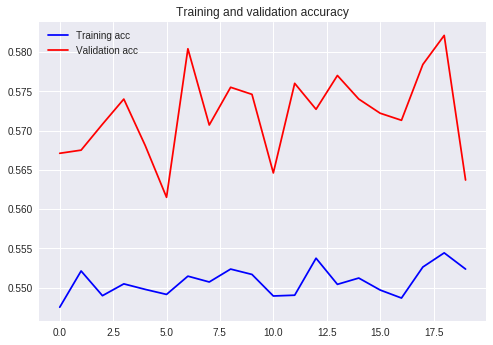

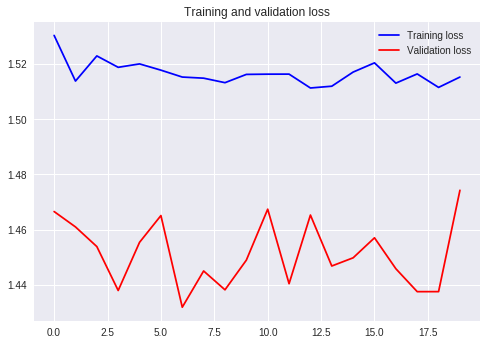

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epoch = range(len(acc))
 
plt.plot(epoch, acc, 'b', label='Training acc')
plt.plot(epoch, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epoch, loss, 'b', label='Training loss')
plt.plot(epoch, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()